# Downloading the data

To download the data, you need:
1. Get your Kaggle API key
2. Move the downloaded **kaggle.json** file into your working directory
3. Run the following to set up the Kaggle API:

    ```bash
    pip install -q kaggle
    mkdir ~/.kaggle
    cp kaggle.json ~/.kaggle/
    chmod 600 ~/.kaggle/kaggle.json
    ```
4. Download the dataset by running this command:
    ```bash
    kaggle datasets download devanshusingh/machine-translation-dataset-de-en
    ```
5. Unzip the download file:
    ```bash
    unzip devanshusingh/machine-translation-dataset-de-en
    ```

In [5]:
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as opt
from torch.nn import functional as F
from datasets import load_dataset
from transformers import BertTokenizer, NllbTokenizer, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

import os

# Set Hyperparameters and Load the Data

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = "machine-translation-dataset-de-en"
TRAIN_PATH = os.path.join(DATA_PATH, "translation_train.csv")
TEST_PATH = os.path.join(DATA_PATH, "translation_test.csv")

In [7]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
train_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/machine-translation-dataset-de-en/translation_train.csv'

# Exploratory Data Analysis

In [ ]:
# What is the length of the datasets?
print(f"{len(train_df)=}")
print(f"{len(test_df)=}")

len(train_df)=29000
len(test_df)=1000


In [ ]:
# What is the avarage length of sentences 
len_en_train_sentences = [len(i.split()) for i in train_df["english"]]
len_ge_train_sentences = [len(i.split()) for i in train_df["german"]]
len_en_test_sentences = [len(i.split()) for i in test_df["english"]]
len_ge_test_sentences = [len(i.split()) for i in test_df["german"]]

avg_en_train_length = np.mean(len_en_train_sentences)
avg_ge_train_length = np.mean(len_ge_train_sentences)
avg_en_test_length = np.mean(len_en_test_sentences)
avg_ge_test_length = np.mean(len_ge_test_sentences)

print(f"{avg_en_train_length=}")
print(f"{avg_ge_train_length=}")
print(f"{avg_en_test_length=}")
print(f"{avg_ge_test_length=}")

avg_en_train_length=11.897241379310344
avg_ge_train_length=11.116655172413793
avg_en_test_length=11.877
avg_ge_test_length=10.912


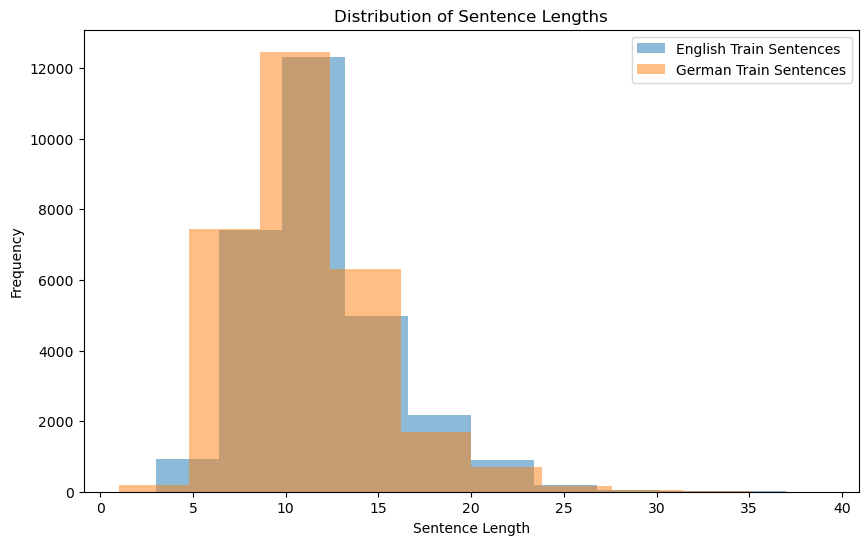

In [ ]:
# What is the distribution of length of train sentences
plt.figure(figsize=(10, 6))
plt.hist(len_en_train_sentences, bins=10, alpha=0.5, label='English Train Sentences')
plt.hist(len_ge_train_sentences, bins=10, alpha=0.5, label='German Train Sentences')

# Add labels and title
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.legend()

# Display the plot
plt.show()

In [8]:
# What is the distribution of length of test sentences
plt.figure(figsize=(10, 6))

# Plot the distributions
plt.hist(len_en_test_sentences, bins=10, alpha=0.5, label='English Test Sentences')
plt.hist(len_ge_test_sentences, bins=10, alpha=0.5, label='German Test Sentences')

# Add labels and title
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.legend()

# Display the plot
plt.show()

NameError: name 'len_en_test_sentences' is not defined

<Figure size 720x432 with 0 Axes>

In [9]:
# What is the 95th percentile of lengths?
en_train_length_95_percentile = np.percentile(len_en_train_sentences, 95)
ge_train_length_95_percentile = np.percentile(len_ge_train_sentences, 95)
en_test_length_95_percentile = np.percentile(len_en_test_sentences, 95)
ge_test_length_95_percentile = np.percentile(len_ge_test_sentences, 95)

print(f"{en_train_length_95_percentile=}")
print(f"{ge_train_length_95_percentile=}")
print(f"{en_test_length_95_percentile=}")
print(f"{ge_test_length_95_percentile=}")

NameError: name 'len_en_train_sentences' is not defined

# Create Datasets and Dataloaders

In [10]:
X_train_raw, y_train_raw = train_df["english"], train_df["german"]
X_test_raw, y_test_raw = test_df["english"], test_df["german"]

NameError: name 'train_df' is not defined

## Creating a custom dataset

In [14]:
MAX_LENGTH = 22
# Initialize the english tokenizer
tokenizer_en = BertTokenizer.from_pretrained("bert-base-cased")

# Initialize the german tokenizer
tokenizer_ge = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")

In [11]:
class TranslationDataset(Dataset):
    def __init__(self, src_data, trg_data, src_tokenizer, trg_tokenizer, max_length=22):
        super().__init__()
        # Tokenize th data 
        self.src_data = src_data
        self.trg_data = trg_data
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer
        self.max_length = max_length # Sequence length
        self.src_sos_token = torch.tensor(src_tokenizer.convert_tokens_to_ids(["[CLS]"]), dtype=torch.int64)
        self.src_eos_token = torch.tensor(src_tokenizer.convert_tokens_to_ids(["[SEP]"]), dtype=torch.int64)
        self.src_pad_token = torch.tensor(src_tokenizer.convert_tokens_to_ids(["[PAD]"]), dtype=torch.int64)
        
        self.trg_sos_token = torch.tensor(trg_tokenizer.convert_tokens_to_ids(["[CLS]"]), dtype=torch.int64)
        self.trg_eos_token = torch.tensor(trg_tokenizer.convert_tokens_to_ids(["[SEP]"]), dtype=torch.int64)
        self.trg_pad_token = torch.tensor(trg_tokenizer.convert_tokens_to_ids(["[PAD]"]), dtype=torch.int64)
    
    def __len__(self):
        return len(self.src_data)
    
    def __getitem__(self, idx):
        # Tokenize the data
        src_text = self.src_data[idx]
        trg_text = self.trg_data[idx]

        src_tokens = self.src_tokenizer(src_text, add_special_tokens=False, padding=False, truncation=True, max_length=self.max_length-2)["input_ids"]
        trg_tokens = self.trg_tokenizer(trg_text, add_special_tokens=False, padding=False, truncation=True, max_length=self.max_length-1)["input_ids"]
        
        src_num_padding_tokens = self.max_length - len(src_tokens) - 2
        trg_num_padding_tokens = self.max_length - len(trg_tokens) - 1

        # Add sos and eos tokens to the beginning and the end of sequences respectively
        enc_input = torch.cat(
            [
                self.src_sos_token,
                torch.tensor(src_tokens, dtype=torch.int64),
                self.src_eos_token,
                torch.tensor([self.src_pad_token] * src_num_padding_tokens, dtype=torch.int64)
            ]
        )

        dec_input = torch.cat(
            [
                self.trg_sos_token,
                torch.tensor(trg_tokens, dtype=torch.int64),
                torch.tensor([self.trg_pad_token] * trg_num_padding_tokens, dtype=torch.int64)
            ]
        )

        label = torch.cat(
            [
                torch.tensor(trg_tokens, dtype=torch.int64),
                self.trg_eos_token,
                torch.tensor([self.trg_pad_token] * trg_num_padding_tokens, dtype=torch.int64)
            ]
        )

        assert enc_input.size(0) == self.max_length
        assert dec_input.size(0) == self.max_length
        assert label.size(0) == self.max_length


        return {
            "encoder_input": enc_input, # (max_length)
            "decoder_input": dec_input, # (max_length)
            "enc_mask": (enc_input != self.src_pad_token).unsqueeze(0).unsqueeze(0).int(), # (1, 1, max_length)
            "dec_mask": (dec_input != self.trg_pad_token).unsqueeze(0).unsqueeze(0).int() & self._attention_mask(dec_input.size(0)), # (1, max_length) & (1, max_length, max_length)
            "label": label, # max_length
            "src_text": src_text,
            "trg_text": trg_text
        }

    def _attention_mask(self, size):
        mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int)
        return mask == 0

In [14]:
train_dataset = TranslationDataset(X_train_raw, y_train_raw, tokenizer_en, tokenizer_ge, max_length=MAX_LENGTH)
test_dataset = TranslationDataset(X_test_raw, y_test_raw, tokenizer_en, tokenizer_ge, max_length=MAX_LENGTH)

In [15]:
# Create the data loader
batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embed, max_length, n_heads, head_size):
        super(MultiHeadAttention, self).__init__()
        self.query = nn.Linear(n_embed, n_embed)
        self.key = nn.Linear(n_embed, n_embed)
        self.value = nn.Linear(n_embed, n_embed)
        self.n_heads = n_heads
        self.head_size = head_size
        self.projection = nn.Linear(n_embed, n_embed)
    
    @staticmethod
    def attention(q, k, v, mask=None):
        d_k = k.shape[-1]
        
        dot_product = torch.matmul(q, k.transpose(-2, -1)) # (batch_size, n_heads, seq_len, seq_len)
        scaled_dot_product = dot_product * d_k ** -0.5
        attention_scores = scaled_dot_product    
        
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float("-inf"))
        
        attention_scores = F.softmax(attention_scores, dim=-1) # (batch_size, n_heads, seq_len, seq_len)
        out = torch.matmul(attention_scores, v) # (batch_size, n_heads, seq_len, head_size)
        return out
        
    def forward(self, q, k, v, mask=None):
        query = self.query(q) # (batch_size, seq_len, d_model)
        key = self.key(k) # (batch_size, seq_len, d_model)
        value = self.value(v) # (batch_size, seq_len, d_model)
        
        # (batch_size, seq_len, d_model) --> (batch_size, seq_len, n_heads, head_size) --> (batch_size, n_heads, seq_len, head_size)
        query = query.view(query.shape[0], query.shape[1], self.n_heads, self.head_size).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.n_heads, self.head_size).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.n_heads, self.head_size).transpose(1, 2)
        
        # (batch_size, n_heads, seq_len, head_size)
        x = MultiHeadAttention.attention(query, key, value, mask) 
        # (batch_size, n_heads, seq_len, head_size) --> (batch_size, seq_len, n_heads * head_size == d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.n_heads * self.head_size)
        # (batch_size, seq_len, d_model) --> (batch_size, seq_len, d_model)
        x = self.projection(x)
        return x
    
class FeedForward(nn.Module):
    def __init__(self, n_embed, dropout_p):
        super(FeedForward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(4 * n_embed, n_embed))
    
    def forward(self, x):
        return self.net(x)
    
class EncoderBlock(nn.Module):
    def __init__(self, n_embed, max_length, n_heads, dropout_p):
        super(EncoderBlock, self).__init__()
        head_size = n_embed // n_heads
        self.sa = MultiHeadAttention(n_embed, max_length, n_heads, head_size)
        self.ffwd = FeedForward(n_embed, dropout_p) 
        self.norm1 = nn.LayerNorm(n_embed)
        self.norm2 = nn.LayerNorm(n_embed)
        self.dropout = nn.Dropout(dropout_p)
    
    def forward(self, x, mask=None):
        # Residual connections
        x = self.norm1(x + self.dropout(self.sa(x, x, x, mask)))
        x = self.norm2(x + self.dropout(self.ffwd(x)))
        return x
    
class Encoder(nn.Module):
    def __init__(self, vocab_size, n_embed, max_length, n_heads, n_layers, dropout_p):
        super(Encoder, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.pos_embedding = nn.Embedding(max_length, n_embed)
        self.blocks = nn.ModuleList([
            EncoderBlock(n_embed, max_length, n_heads, dropout_p) for _ in range(n_layers)
        ])       
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x, mask=None):
        B, T = x.shape
        token_embed = self.token_embedding(x)
        positional_embed = self.pos_embedding(torch.arange(T, device=DEVICE))
        embedding = self.dropout(token_embed + positional_embed)

        x = embedding
        for block in self.blocks:
            x = block(embedding, mask)
        return x
    
class DecoderBlock(nn.Module):
    """Decoder Block"""
    def __init__(self, n_embed, max_length, n_heads, dropout_p):
        super(DecoderBlock, self).__init__()
        head_size = n_embed // n_heads
        self.sa = MultiHeadAttention(n_embed, max_length, n_heads, head_size) # masked self-attention 
        self.encoder_decoder_attention = MultiHeadAttention(n_embed, max_length, n_heads, head_size)
        self.ffwd = FeedForward(n_embed, dropout_p)
        self.norm1 = nn.LayerNorm(n_embed)
        self.norm2 = nn.LayerNorm(n_embed)
        self.norm3 = nn.LayerNorm(n_embed)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x, encoder_output, decoder_mask, padding_mask=None):
        x = self.norm1(x + self.dropout(self.sa(x, x, x, decoder_mask)))
        self.encoder_decoder_attention(x, encoder_output, encoder_output, padding_mask)
        x = self.norm2(x + self.dropout(self.encoder_decoder_attention(x, encoder_output, encoder_output, padding_mask)))
        x = self.norm3(x + self.dropout(self.ffwd(x)))
        return x
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, n_embed, max_length, n_heads, n_layers, dropout_p):
        super(Decoder, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.pos_embedding = nn.Embedding(max_length, n_embed)
        self.blocks = nn.ModuleList([
            DecoderBlock(n_embed, max_length, n_heads, dropout_p) for _ in range(n_layers)
        ])
        self.lm_head = nn.Linear(n_embed, vocab_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x, enc_out, decoder_mask, padding_mask=None):
        B, T = x.shape
        token_embed = self.token_embedding(x)
        pos_embed = self.pos_embedding(torch.arange(T, device=DEVICE))
        embedding = self.dropout(token_embed + pos_embed)

        x = embedding
        for block in self.blocks:
            x = block(x, enc_out, decoder_mask, padding_mask)

        x = self.lm_head(x)
        return x

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trgt_vocab_size, n_embed, max_length, n_heads, n_layers, dropout_p):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, n_embed, max_length, n_heads, n_layers, dropout_p).to(DEVICE)
        self.decoder = Decoder(trgt_vocab_size, n_embed, max_length, n_heads, n_layers, dropout_p).to(DEVICE)

    def _make_padding_mask(self, src):
        mask = (src != self.pad_idx).unsqueeze(1).to(DEVICE)
        return mask

    def _make_decoder_mask(self, trg):
        B, T = trg.shape
        mask = torch.tril(torch.ones((B, T, T))).to(DEVICE)
        return mask

    def forward(self, x, y, padding_mask, decoder_mask):
#         padding_mask = self._make_padding_mask(x)
#         decoder_mask = self._make_decoder_mask(y)
        encoder_output = self.encoder(x, padding_mask)
        out = self.decoder(y, encoder_output, decoder_mask, padding_mask).to(DEVICE)
        return out

In [15]:
vocab_size_en = tokenizer_en.vocab_size
vocab_size_ge = tokenizer_ge.vocab_size

In [16]:
vocab_size_en, vocab_size_ge

(28996, 31102)

In [17]:
model = Transformer(
    src_vocab_size=vocab_size_en, 
    trgt_vocab_size=vocab_size_ge,
    n_embed=512,
    max_length=MAX_LENGTH,
    n_heads=8, 
    n_layers=8, 
    dropout_p=0.2
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(model.parameters(), lr=0.0001)

In [18]:
torch.save(model.state_dict(), "transformer.pt")

In [25]:
def train(model=model, train_data_loader=train_data_loader, test_data_loader=test_data_loader, src_tokenizer=tokenizer_en, trg_tokenizer=tokenizer_ge, num_epochs=5, eos_token=103):
    vocab_size_ge = trg_tokenizer.vocab_size
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            # Load the data
            encoder_input = batch["encoder_input"].to(DEVICE)
            decoder_input = batch["decoder_input"].to(DEVICE)
            encoder_mask = batch["enc_mask"].to(DEVICE)
            decoder_mask = batch["dec_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            trg_text = batch["trg_text"]
                
            optimizer.zero_grad()
            outputs = model(encoder_input, decoder_input, encoder_mask, decoder_mask)
            loss = criterion(outputs.view(-1, vocab_size_ge), labels.view(-1))
            
            # Backprop
            loss.backward()
            
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

        
        
        print("--------------------------------------------------")
        print(f"ENGLISH: {src_tokenizer.decode(encoder_input[0])} \n")
        
        ge_sentence_predicted = torch.argmax(outputs[0], axis=1)
        predicted_sentence = []
        for idx in ge_sentence_predicted:
            if idx == eos_token:
                break
            predicted_sentence.append(idx.item())
            
        predicted_sentence_decoded = trg_tokenizer.decode(predicted_sentence)
            
        print(f"ACTUAL GERMAN SENTENCE: {trg_text[0]} \n")
        print(f"GERMAN PREDICTION: {predicted_sentence_decoded} \n")
        bleu_score = sentence_bleu(trg_text[0], predicted_sentence_decoded)
        print(f"BLEU SCORE: {bleu_score}")

    print("Training complete!")

In [26]:
# Train the model
train(num_epochs=8)

Epoch 1/8, Loss: 3.3375
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

ENGLISH: [CLS] A snowboarder is attempting a jump on a crafted ski run. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

ACTUAL GERMAN SENTENCE: Ein Snowboarder versucht auf einer hergerichteten Skipiste zu springen. 

GERMAN PREDICTION: Ein Snowboarder fährt einen einem Bank auf auf Kopf. auf.. 

BLEU SCORE: 0.7565391407404769


Epoch 2/8, Loss: 2.2549
--------------------------------------------------
ENGLISH: [CLS] A man in an orange hard hat operating heavy machinery. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

ACTUAL GERMAN SENTENCE: Ein Mann mit einem orangefarbenen Schutzhelm, Bedient schwere Maschinen. 

GERMAN PREDICTION: Ein Mann in orange orangefarbenen Huthelmen der ein einen ein. 

BLEU SCORE: 0.7440300527604121


Epoch 3/8, Loss: 1.8328
--------------------------------------------------
ENGLISH: [CLS] A little girl walks on a path of an indoor garden. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

ACTUAL GERMAN SENTENCE: Ein kleines Mädchen geht auf einem Pfad in einem Gewächshaus. 

GERMAN PREDICTION: Ein kleines Mädchen läuft auf einem Weg von einem Waldand.. 

BLEU SCORE: 0.7630350645544293


Epoch 4/8, Loss: 1.5536
--------------------------------------------------
ENGLISH: [CLS] Workers in bright orange vests on the railway platform. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

ACTUAL GERMAN SENTENCE: Arbeiter in hell orangefarbenen Westen auf dem Bahnsteig. 

GERMAN PREDICTION: Arbeiter in leuchten orangefarbenen Westen auf dem Boden. 

BLEU SCORE: 0.7790872728179328


Epoch 5/8, Loss: 1.3495
--------------------------------------------------
ENGLISH: [CLS] Dirt bikers traverse a series of jumps. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

ACTUAL GERMAN SENTENCE: Geländemotorradfahrer fahren über eine Reihe von Sprüngen. 

GERMAN PREDICTION: Einmotorradfahrer fahren auf eine Art von hohenausrüstunge. 

BLEU SCORE: 0.721634009677548


Epoch 6/8, Loss: 1.1853
--------------------------------------------------
ENGLISH: [CLS] Young man in green shirt play xylophone for crowd in public area. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] 

ACTUAL GERMAN SENTENCE: Ein junger Mann in grünem Hemd spielt Xylophon für eine Menschenmenge in einer öffentlichen Zone. 

GERMAN PREDICTION: Ein junger Mann in grünem Hemd spielt inylophon in eine Menschenmenge in einer öffentlichen Umgebung. 

BLEU SCORE: 0.7123000806985262


Epoch 7/8, Loss: 1.0498
--------------------------------------------------
ENGLISH: [CLS] A person wearing a red shirt is falling off a white surfboard. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

ACTUAL GERMAN SENTENCE: Jemand in einem roten Hemd fällt von einem weißen Surfbrett. 

GERMAN PREDICTION: Eine in einem roten Oberd fällt von einem weißen Surfbrett. 

BLEU SCORE: 0.7533128875407774


Epoch 8/8, Loss: 0.9331
--------------------------------------------------
ENGLISH: [CLS] A man has just won from a karate battle with his opponent and his nose is bleeding. [SEP] [PAD] 

ACTUAL GERMAN SENTENCE: Ein Mann mit blutender Nase hat soeben einen Karatekampf gewonnen. 

GERMAN PREDICTION: Ein Mann hat einemen wird, hat ein einen Karateanz aus, 

BLEU SCORE: 0.7344112539787184
Training complete!


# Evaluate on the test sentences

In [29]:
with torch.no_grad():
    model.eval()
    for batch in test_data_loader:
        encoder_input = batch["encoder_input"].to(DEVICE)
        decoder_input = batch["decoder_input"].to(DEVICE)
        encoder_mask = batch["enc_mask"].to(DEVICE)
        decoder_mask = batch["dec_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        trg_text = batch["trg_text"]
        
        outputs = model(encoder_input, decoder_input, encoder_mask, decoder_mask)

        print(f"English: {tokenizer_en.decode(encoder_input[0])}")
        ge_sentence_predicted = torch.argmax(outputs[0], axis=1)
        predicted_sentence = []
        for idx in ge_sentence_predicted:
            if idx == 103:
                break
            predicted_sentence.append(idx.item())
        print()
        print(f"German Prediction: {tokenizer_ge.decode(predicted_sentence)}")
        print()
        print(f"ACTUAL GERMAN SENTENCE: {trg_text[0]}")
        print()
        print(F"BLEU SCORE: {sentence_bleu(trg_text[0], tokenizer_ge.decode(predicted_sentence))}")

English: [CLS] A man in an orange hat starring at something. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

German Prediction: Ein Mann mit einem orangefarbenen Hut star der etwas issrt.

ACTUAL GERMAN SENTENCE: Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.

BLEU SCORE: 0.7630350645544293
English: [CLS] A child is splashing in the water [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

German Prediction: Ein Kind planscht im Wasser.

ACTUAL GERMAN SENTENCE: Ein Kind planscht im Wasser.

BLEU SCORE: 0.8954237688029468
English: [CLS] A boy and his younger brother playing together at the playground. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

German Prediction: Ein Junge und sein jüngere Bruder spielen zusammen am dem Spielplatz.

ACTUAL GERMAN SENTENCE: Ein Junge und sein jüngerer Bruder spielen gemeinsam auf einem Spielplatz.

BLEU SCORE: 0.7514384223429621
English: [CLS] Three men in same colored vests are in the 

# Save the model

In [34]:
sentence_bleu([["hello you"]], [["hello you"]])

TypeError: unhashable type: 'list'

In [ ]:
torch.save(model.state_dict(), "transformer.pt")

In [41]:
tokenizer_ge.decode(predicted_sentence)

'Dies ist ein Mann gekleideter Mann, der ein Hand eines eines braunes Pferds hält.'

In [46]:
sentence_bleu(trg_text[0], tokenizer_ge.decode(predicted_sentence))

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7219122568893311

In [50]:
reference = [['hello', 'everyone']]
predicted = ['hello', 'everyone']

sentence_bleu(reference, predicted)

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


1.0

# Test on custom sentences

In [ ]:
# Load the model
trained_model = Transformer(vocab_size_en, vocab_size_ge, 512, MAX_LENGTH, 8, 8, 0.1).to(DEVICE)
trained_model.load_state_dict(torch.load("transformer.pt"))

In [ ]:
def tokenize_and_mask_for_translation(trg, trg_tokenizer=tokenizer_ge, max_length=MAX_LENGTH):
    def attention_mask(size):
        mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int).to(DEVICE)
        return mask == 0
    
    trg_pad_token = torch.tensor(trg_tokenizer.convert_tokens_to_ids(["[PAD]"]), dtype=torch.int64).to(DEVICE)
    trg_num_padding_tokens = max_length - len(trg)
    
    dec_input = torch.cat(
            [
                trg.to(DEVICE),  
                torch.tensor([trg_pad_token] * trg_num_padding_tokens, dtype=torch.int64).to(DEVICE)
            ]
        ).unsqueeze(0).to(DEVICE)
    
    mask = (dec_input != trg_pad_token).unsqueeze(0).unsqueeze(0).int() & attention_mask(dec_input.size(1)) 
    
    return {
        "dec_input": dec_input,
        "mask": mask
    }


In [ ]:
def translate(src_sentence, model=trained_model, src_tokenizer=tokenizer_en, trg_tokenizer=tokenizer_ge, max_length=MAX_LENGTH, sos_token=102, eos_token=103):
    model.eval()
    
    src = src_tokenizer([src_sentence], padding="max_length", truncation=True, max_length=max_length)
    enc_input = torch.tensor(src["input_ids"]).to(DEVICE)
    src_mask = torch.tensor(src["attention_mask"]).to(DEVICE)
    
    # Create initial translation with the start-of-sentence token
    trg_tokens = torch.tensor(trg_tokenizer.convert_tokens_to_ids(["[CLS]"]), dtype=torch.int64)
    
    with torch.no_grad():
        for word in range(max_length):
            dec_input, dec_mask = tokenize_and_mask_for_translation(trg_tokens).values()
            logits = model(enc_input, dec_input.to(DEVICE), src_mask, dec_mask.to(DEVICE))
            next_word_prob_distribution = logits[0][word]
            next_token = torch.argmax(next_word_prob_distribution).item()
 
            if next_token == eos_token:
                break
            
            # Append to trg_tokens
            trg_tokens = torch.cat((trg_tokens.to(DEVICE), torch.tensor([next_token]).to(DEVICE)), dim=0)

#             # Append the next predicted token to the target sequence
#             trg = torch.cat((trg, torch.tensor([[next_word]]).to(DEVICE)), dim=1)

    # Convert the target sequence to a list of token IDs
#     translated_tokens = trg.squeeze().tolist()

    # Decode the token IDs to words using the target tokenizer
    translated_sentence = trg_tokenizer.decode(trg_tokens[1:])

    return translated_sentence


In [ ]:
translate("The white fox is chasing a rabbit")